In [1]:
import coiled
import dask
import odc.geo.xr  # noqa
import xarray as xr
import xclim
from odc.geo import CRS

from ocr.datasets import catalog, load_conus404
from ocr.risks.fire import classify_wind_directions, direction_histogram, nws_fire_weather

In [2]:
args = {
    'name': 'fire-weather-distribution',
    'region': 'us-west-2',
    'n_workers': [4, 50],
    'tags': {'Project': 'OCR'},
    'worker_vm_types': 'm8g.xlarge',
    'scheduler_vm_types': 'm8g.large',
}
cluster = coiled.Cluster(**args)
client = cluster.get_client()

Output()

╭──────────────────────────────── Package Info ────────────────────────────────╮
│           ╷                                                                  │
│   Package │ Note                                                             │
│ ╶─────────┼────────────────────────────────────────────────────────────────╴ │
│   ocr     │ Wheel built from                                                 │
│           │ /opt/coiled/env/.path-deps/ocr-999.post112+g368df4959.d2025082   │
│           │ 2-py3-none-any.whl                                               │
│           ╵                                                                  │
╰──────────────────────────────────────────────────────────────────────────────╯

Output()

2025-08-22 16:28:16,575 - distributed.deploy.adaptive - INFO - Adaptive scaling started: minimum=4 maximum=50


In [3]:
%%time
ds = load_conus404()
ds.lat.load()
ds.lon.load()
ds

CPU times: user 673 ms, sys: 117 ms, total: 790 ms
Wall time: 28.2 s


<xarray.Dataset> Size: 13TB
Dimensions:   (time: 376945, y: 1015, x: 1367)
Coordinates:
  * time      (time) datetime64[ns] 3MB 1979-10-01 ... 2022-10-01
  * x         (x) float64 11kB -2.732e+06 -2.728e+06 ... 2.728e+06 2.732e+06
  * y         (y) float64 8kB -2.028e+06 -2.024e+06 ... 2.024e+06 2.028e+06
    crs       int64 8B 1
    lat       (y, x) float32 6MB 17.65 17.66 17.67 17.68 ... 51.73 51.71 51.69
    lon       (y, x) float32 6MB -122.6 -122.5 -122.5 ... -57.17 -57.12 -57.07
Data variables:
    PSFC      (time, y, x) float32 2TB dask.array<chunksize=(376945, 10, 10), meta=np.ndarray>
    Q2        (time, y, x) float32 2TB dask.array<chunksize=(376945, 10, 10), meta=np.ndarray>
    T2        (time, y, x) float32 2TB dask.array<chunksize=(376945, 10, 10), meta=np.ndarray>
    TD2       (time, y, x) float32 2TB dask.array<chunksize=(376945, 10, 10), meta=np.ndarray>
    U10       (time, y, x) float32 2TB dask.array<chunksize=(376945, 10, 10), meta=np.ndarray>
    V10       (time, y, x) float32 2TB dask.array<chunksize=(376945, 10, 10), meta=np.ndarray>
    SINALPHA  (y, x) float32 6MB dask.array<chunksize=(175, 175), meta=np.ndarray>
    COSALPHA  (y, x) float32 6MB dask.array<chunksize=(175, 175), meta=np.ndarray>
Attributes: (12/148)
    AER_ANGEXP_OPT:                  1
    AER_ANGEXP_VAL:                  1.2999999523162842
    AER_AOD550_OPT:                  1
    AER_AOD550_VAL:                  0.11999999731779099
    AER_ASY_OPT:                     1
    AER_ASY_VAL:                     0.8999999761581421
    ...                              ...
    WEST-EAST_PATCH_START_STAG:      1
    WEST-EAST_PATCH_START_UNSTAG:    1
    W_DAMPING:                       1
    YSU_TOPDOWN_PBLMIX:              0
    history:                         Tue Mar 29 16:35:22 2022: ncrcat -A -vW ...
    history_of_appended_files:       Tue Mar 29 16:35:22 2022: Appended file ...

In [4]:
hurs = xclim.indicators.atmos.relative_humidity_from_dewpoint(tas=ds['T2'], tdps=ds['TD2'])
hurs

/opt/coiled/env/lib/python3.13/site-packages/xclim/core/cfchecks.py:79: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


<xarray.DataArray 'hurs' (time: 376945, y: 1015, x: 1367)> Size: 2TB
dask.array<where, shape=(376945, 1015, 1367), dtype=float32, chunksize=(376945, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 3MB 1979-10-01 ... 2022-10-01
  * x        (x) float64 11kB -2.732e+06 -2.728e+06 ... 2.728e+06 2.732e+06
  * y        (y) float64 8kB -2.028e+06 -2.024e+06 ... 2.024e+06 2.028e+06
    crs      int64 8B 1
    lat      (y, x) float32 6MB 17.65 17.66 17.67 17.68 ... 51.73 51.71 51.69
    lon      (y, x) float32 6MB -122.6 -122.5 -122.5 ... -57.17 -57.12 -57.07
Attributes:
    units:          %
    cell_methods:   
    history:        tas: \ntdps: \n[2025-08-22 16:28:44] hurs: HURS_FROMDEWPO...
    standard_name:  relative_humidity
    long_name:      Relative humidity ("sonntag90" method)
    description:    Computed from temperature, and dew point temperature thro...

In [5]:
# rotate the grid-relative winds to earth-relative winds: https://forum.mmm.ucar.edu/threads/rotating-wrf-u-and-v-winds-before-and-after-reprojection.11788/
# earth_u = u*cosa(ix,iy)-v*sina(ix,iy)
# earth_v = v*cosa(ix,iy)+u*sina(ix,iy)
with xr.set_options(keep_attrs=True):
    earth_u = ds.U10 * ds.COSALPHA - ds.V10 * ds.SINALPHA
    earth_v = ds.V10 * ds.COSALPHA + ds.U10 * ds.SINALPHA

winds = xclim.indicators.atmos.wind_speed_from_vector(uas=earth_u, vas=earth_v)
wind = xr.merge(winds)
wind

/opt/coiled/env/lib/python3.13/site-packages/xclim/core/cfchecks.py:79: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


<xarray.Dataset> Size: 4TB
Dimensions:         (time: 376945, x: 1367, y: 1015)
Coordinates:
  * time            (time) datetime64[ns] 3MB 1979-10-01 ... 2022-10-01
  * x               (x) float64 11kB -2.732e+06 -2.728e+06 ... 2.732e+06
  * y               (y) float64 8kB -2.028e+06 -2.024e+06 ... 2.028e+06
    crs             int64 8B 1
    lat             (y, x) float32 6MB 17.65 17.66 17.67 ... 51.73 51.71 51.69
    lon             (y, x) float32 6MB -122.6 -122.5 -122.5 ... -57.12 -57.07
Data variables:
    sfcWind         (time, y, x) float32 2TB dask.array<chunksize=(376945, 10, 10), meta=np.ndarray>
    sfcWindfromdir  (time, y, x) float32 2TB dask.array<chunksize=(376945, 10, 10), meta=np.ndarray>
Attributes:
    units:          m s-1
    cell_methods:   
    history:        uas: \nvas: \n[2025-08-22 16:28:46] sfcWind: WIND_SPEED_F...
    standard_name:  wind_speed
    long_name:      Near-surface wind speed
    description:    Wind speed computed as the magnitude of the (uas, vas) ve...

In [6]:
fire_weather_mask = nws_fire_weather(
    hurs,
    15,
    # reason that wind gusts are typically ~40% higher than average wind speed
    # and we want to base this on wind gusts (need a citation for this)
    wind['sfcWind'] * 1.4,
    35,
)
fire_weather_mask

<xarray.DataArray (time: 376945, y: 1015, x: 1367)> Size: 523GB
dask.array<and_, shape=(376945, 1015, 1367), dtype=bool, chunksize=(376945, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 3MB 1979-10-01 ... 2022-10-01
  * x        (x) float64 11kB -2.732e+06 -2.728e+06 ... 2.728e+06 2.732e+06
  * y        (y) float64 8kB -2.028e+06 -2.024e+06 ... 2.024e+06 2.028e+06
    crs      int64 8B 1
    lat      (y, x) float32 6MB 17.65 17.66 17.67 17.68 ... 51.73 51.71 51.69
    lon      (y, x) float32 6MB -122.6 -122.5 -122.5 ... -57.17 -57.12 -57.07

In [7]:
direction_indices = classify_wind_directions(wind['sfcWindfromdir'])
masked_direction_indices = direction_indices.where(fire_weather_mask)
masked_direction_indices

<xarray.DataArray 'wind_direction_classification' (time: 376945, y: 1015,
                                                   x: 1367)> Size: 2TB
dask.array<where, shape=(376945, 1015, 1367), dtype=float32, chunksize=(376945, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 3MB 1979-10-01 ... 2022-10-01
  * x        (x) float64 11kB -2.732e+06 -2.728e+06 ... 2.728e+06 2.732e+06
  * y        (y) float64 8kB -2.028e+06 -2.024e+06 ... 2.024e+06 2.028e+06
    crs      int64 8B 1
    lat      (y, x) float32 6MB 17.65 17.66 17.67 17.68 ... 51.73 51.71 51.69
    lon      (y, x) float32 6MB -122.6 -122.5 -122.5 ... -57.17 -57.12 -57.07
Attributes:
    long_name:         wind direction classified into 8 cardinal directions (...
    short_name:        wind_direction_classification
    direction_labels:  ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']

In [9]:
# create the distribution of winds based upon the classified wind directions
# if there are nans in the mix, they won't contribute to the distribution
fraction = direction_histogram(masked_direction_indices)

# sum up the fractions of all of the wind directions. if any pixel sums to zero it will
# fall into the no_fire_weather mask and be cast to a `nan`. if any pixel has any fraction
# of timestamps with fire weather then it will be cast into the mask where there *is* fire weather
no_fire_weather = fraction.sum(dim='wind_direction')
mode = fraction.argmax(dim='wind_direction').where(no_fire_weather).chunk({'x': -1, 'y': -1})
mode = dask.optimize(mode)[0]
mode

<xarray.DataArray 'wind_direction_histogram' (y: 1015, x: 1367)> Size: 11MB
dask.array<rechunk-merge, shape=(1015, 1367), dtype=float64, chunksize=(1015, 1367), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 11kB -2.732e+06 -2.728e+06 ... 2.728e+06 2.732e+06
  * y        (y) float64 8kB -2.028e+06 -2.024e+06 ... 2.024e+06 2.028e+06
    crs      int64 8B 1
    lat      (y, x) float32 6MB dask.array<chunksize=(1015, 1367), meta=np.ndarray>
    lon      (y, x) float32 6MB dask.array<chunksize=(1015, 1367), meta=np.ndarray>

In [11]:
%%time
path_non_reprojected = (
    's3://carbonplan-ocr/intermediate/met-data/conus404/fire_weather_wind_mode-hurs15_wind35.zarr'
)
mode.to_zarr(path_non_reprojected, mode='w')

mode = xr.open_zarr(path_non_reprojected)

/opt/coiled/env/lib/python3.13/site-packages/zarr/api/asynchronous.py:228: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
/opt/coiled/env/lib/python3.13/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 61.48 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 7.71 s, sys: 229 ms, total: 7.94 s
Wall time: 9min 17s


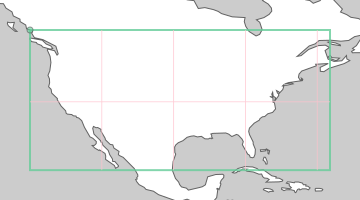

In [12]:
dataset = (
    catalog.get_dataset('USFS-wildfire-risk-communities-4326')
    .to_xarray()
    .astype('float32')[['CRPS']]
)
dataset = dataset.odc.assign_crs('epsg:4326')
dataset.odc.geobox

In [13]:
# Build CRS from the CF grid_mapping variable (spherical LCC)
src_crs = CRS(ds['crs'].attrs['crs_wkt'])
mode_ds = mode.odc.assign_crs(src_crs)
mode_ds

<xarray.Dataset> Size: 22MB
Dimensions:                   (y: 1015, x: 1367)
Coordinates:
    lat                       (y, x) float32 6MB dask.array<chunksize=(1015, 1367), meta=np.ndarray>
    crs                       int64 8B ...
  * x                         (x) float64 11kB -2.732e+06 ... 2.732e+06
    lon                       (y, x) float32 6MB dask.array<chunksize=(1015, 1367), meta=np.ndarray>
  * y                         (y) float64 8kB -2.028e+06 ... 2.028e+06
    spatial_ref               int32 4B 0
Data variables:
    wind_direction_histogram  (y, x) float64 11MB dask.array<chunksize=(1015, 1367), meta=np.ndarray>

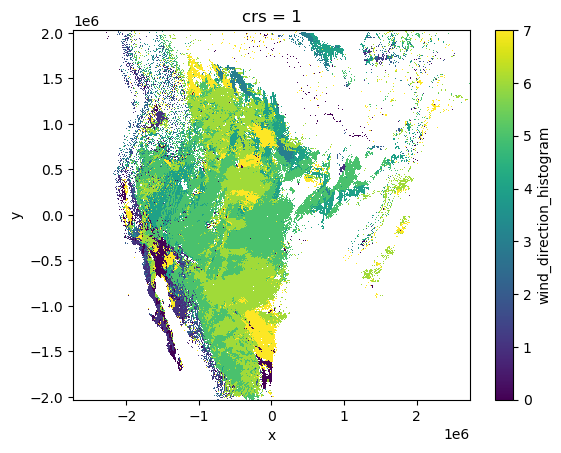

In [21]:
mode.wind_direction_histogram.plot()

In [22]:
result = (
    mode_ds.odc.reproject(dataset.odc.geobox, resampling='nearest')
    .astype('float32')
    .chunk({'latitude': 6000, 'longitude': 4500})
)

result = dask.optimize(result)[0]
result

<xarray.Dataset> Size: 82GB
Dimensions:                   (latitude: 97579, longitude: 208881)
Coordinates:
    crs                       int64 8B ...
  * latitude                  (latitude) float64 781kB 52.48 52.48 ... 22.43
  * longitude                 (longitude) float64 2MB -128.4 -128.4 ... -64.05
    spatial_ref               int32 4B 4326
Data variables:
    wind_direction_histogram  (latitude, longitude) float32 82GB dask.array<chunksize=(6000, 4500), meta=np.ndarray>

In [23]:
%%time
path = 's3://carbonplan-ocr/intermediate/met-data/conus404/fire_weather_wind_mode-hurs15_wind35-reprojected.zarr'
result.to_zarr(path, mode='w')

/opt/coiled/env/lib/python3.13/site-packages/zarr/api/asynchronous.py:228: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


CPU times: user 615 ms, sys: 21.5 ms, total: 637 ms
Wall time: 1min 52s


CPU times: user 1.65 s, sys: 84.9 ms, total: 1.74 s
Wall time: 2.86 s


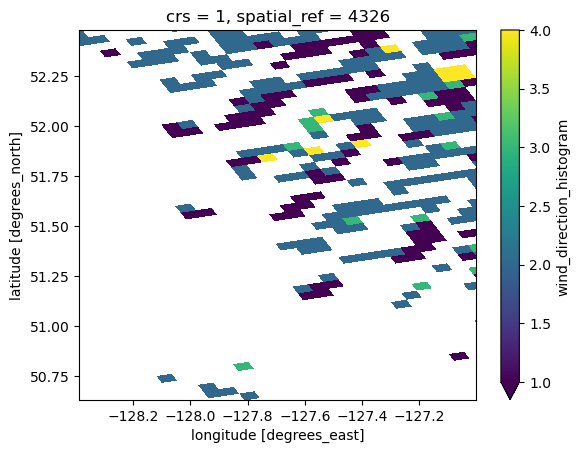

In [24]:
%%time
result = xr.open_zarr(path)
result.wind_direction_histogram.isel(latitude=slice(6000), longitude=slice(4500)).plot(robust=True);